In [19]:
from dotenv import load_dotenv

load_dotenv()

True

In [20]:
from langchain_community.document_loaders import TextLoader

loader = TextLoader("./document/real_estate_tax.md", encoding="utf-8")
documents = loader.load()

In [21]:
from typing_extensions import TypedDict
from langgraph.graph import StateGraph

class AgentState(TypedDict):
    query: str # 질의 내용
    answer: str # 세율 계산
    tax_base_equation: str # 과세 표준 계산 수식
    tax_deduction: str # 공제액
    market_ratio: str # 공정시장가액비율
    tax_base: str # 과세표준 계산

graph_builder = StateGraph(AgentState)

In [22]:
from langchain_chroma import Chroma
from langchain_openai import OpenAIEmbeddings

embedding_function = OpenAIEmbeddings(model="text-embedding-3-large")
vector_store = Chroma(
  embedding_function=embedding_function,
  collection_name="real_estate_tax",
  persist_directory="./chroma_db"  # ✅ 디렉터리
)

retriever = vector_store.as_retriever(search_kwargs={"k": 3})

In [23]:
query = '5억짜리 집 1채, 10억짜리 집 1채, 20억짜리 집 1채를 가지고 있을 때 세금을 얼마나 내나요?'

In [24]:
from langchain_openai import ChatOpenAI

llm = ChatOpenAI(model="gpt-4o", temperature=0)
small_llm = ChatOpenAI(model="gpt-4o-mini", temperature=0)

In [25]:
from langsmith import Client
from langchain_core.output_parsers import StrOutputParser
from langchain_core.runnables import RunnablePassthrough
from langchain_core.prompts import ChatPromptTemplate

client = Client()
rag_prompt = client.pull_prompt("rlm/rag-prompt", include_model=True)

In [26]:

tax_base_retrieval_chain = (
    {'context' : retriever, 'question' : RunnablePassthrough()} 
    | rag_prompt
    | llm
    | StrOutputParser()
)

tax_base_equation_prompt = ChatPromptTemplate.from_messages([
    ('system', '사용자의 질문에서 과세표준을 계산하는 방법을 수식으로 나타내주세요. 부연설명 없이 수식만 리턴해주세요.'),
    ('human', '{tax_base_equation_information}'),
])

tax_base_equation_chain = (
    {'tax_base_equation_information' : RunnablePassthrough()}
    | tax_base_equation_prompt
    | llm
    | StrOutputParser()
)

tax_base_chain = {'tax_base_equation_information' : tax_base_retrieval_chain} | tax_base_equation_chain

def get_tax_base_equation(state: AgentState):
    tax_base_equation_question = '주택에 대한 종합 부동산세 계산시 과세표준을 계산하는 방법을 알려주세요.'
    tax_base_equation = tax_base_chain.invoke(tax_base_equation_question)
    return {'tax_base_equation' : tax_base_equation}

In [27]:
get_tax_base_equation({})

{'tax_base_equation': '과세표준 = (주택의 공시가격 합계 - 공제금액) × 공정시장가액비율'}

In [28]:
tax_deduction_chain = (
    {'context' : retriever, 'question' : RunnablePassthrough()} 
    | rag_prompt
    | llm
    | StrOutputParser()
)

def get_tax_deduction(state: AgentState):
    tax_deduction_question = '주택에 대한 종합 부동산세 계산시 공제금액을 알려주세요.'
    tax_deduction = tax_deduction_chain.invoke(tax_deduction_question)
    return {'tax_deduction' : tax_deduction}

In [29]:
get_tax_deduction({})

{'tax_deduction': '주택에 대한 종합부동산세 계산 시 공제금액은 1세대 1주택자의 경우 12억 원, 법인 또는 법인으로 보는 단체의 경우 6억 원, 그 외의 경우 9억 원입니다.'}

In [30]:
from langchain_community.tools import TavilySearchResults
from datetime import date

tax_market_ratio_prompt = ChatPromptTemplate.from_messages([
    ('system', f'아래 정보를 기반으로 공정시장 가액비율을 계산해주세요\n\nContext:\n{{context}}'),
    ('human', '{query}')
])

tavily_search_tool = TavilySearchResults(
  max_results=5,
  search_depth="advanced",
  include_answer=True,
  include_raw_content=True,
  include_images=True
)

def get_market_ratio(state: AgentState):
    query = f'오늘 날짜:({date.today()})에 해당하는 주택 공시가격 공정시가액비율은 몇%인가요?'
    context = tavily_search_tool.invoke(query)
    print(context)
    tax_market_ratio_chain = (
        tax_market_ratio_prompt
        | llm
        | StrOutputParser()
    )
    market_ratio = tax_market_ratio_chain.invoke({'context' : context, 'query' : query})
    return {'market_ratio' : market_ratio}

In [31]:
get_market_ratio({})

[{'title': '2026년 종부세 공정시장가액비율 80% 상향, 어떤 변화가 올까?', 'url': 'https://mystery225.tistory.com/193', 'content': '카테고리 없음\n\n## 2026년 종부세 공정시장가액비율 80% 상향, 어떤 변화가 올까?\n\nMystic Chronicles 2025. 8. 23. 22:21\n\n안녕하세요, 부동산 세금에 관심 있는 분들을 위한 소식을 전해드리는 부동산 세금 가이드 블로그입니다! 오늘은 2026년에 예정된 종합부동산세(종부세) 공정시장가액비율 80% 상향에 대해 자세히 알아보고, 이 변화가 주택 소유자와 부동산 시장에 어떤 영향을 미칠지 쉽게 풀어볼게요.\n\n종부세와 공정시장가액비율이란?   \n종부세는 고가의 부동산을 보유한 사람들에게 부과되는 세금으로, 주택이나 토지의 공시가격을 기준으로 계산됩니다. 여기서 공정시장가액비율은 공시가격에 곱해져 종부세 과세표준을 결정하는 중요한 요소예요. 쉽게 말해, 공시가격의 일정 비율만 세금 계산에 반영되는 거죠.   \n현재(2025년 기준) 공정시장가액비율은 주택의 경우 60%로 적용되고 있어요. 예를 들어, 공시가격이 10억 원인 주택은 60%인 6억 원을 기준으로 종부세를 계산합니다. 하지만 2026년에는 이 비율이 80%로 상향될 가능성이 높아졌다는 소식이 전해지고 있죠. [...] 왜 80%로 상향되나?   \n정부는 종부세 공정시장가액비율을 60%에서 80%로 올리는 방안을 적극 검토 중이에요. 이는 윤석열 정부가 이전에 낮췄던 종부세 부담을 원상 복구하려는 취지로 보입니다. 특히, 최근 서울 강남권을 중심으로 고가 주택이 증가하면서 세수 확보 필요성이 커졌기 때문이죠.   \n문재인 정부 시절 공정시장가액비율은 95%까지 올랐었지만, 2022년 윤석열 정부 들어 60%로 낮아졌어요. 하지만 세수 부족 문제가 심화되면서, 정부는 비율을 다시 80%로 조정해 세입을 적정 수준으로 맞추려는 계획을 세우고 있는 것으로 보여요. 이

{'market_ratio': '2026년 주택 공시가격에 대한 공정시장가액비율은 80%로 상향될 예정입니다. 이는 2025년까지 60%로 적용되던 비율이 2026년에 80%로 조정되는 것입니다.'}

In [32]:
from langchain_core.prompts import PromptTemplate

tax_base_calculation_prompt = ChatPromptTemplate.from_messages(
  [
    ('system', """
주어진 내용을 기반으로 과세표준을 계산해주세요.
                                                           
과세표준 계산 수식: {tax_base_equation}
공제금액: {tax_deduction}
공정시장가액비율: {market_ratio}
                                                                                                                      
                                                                                                                                                                        
"""),
    ('human', '사용자 주택 공시가격 정보 : {query}')
  ]  
)

def calculate_tax_base(state:AgentState):
  tax_base_equation = state['tax_base_equation'],
  tax_deduction = state['tax_deduction'],
  market_ratio = state['market_ratio']
  query = state['query'],
  tax_base_calculation_chain = (
    tax_base_calculation_prompt
    | llm
    | StrOutputParser()
  )
  tax_base= tax_base_calculation_chain.invoke({
    'tax_base_equation': tax_base_equation,
    'tax_deduction': tax_deduction,
    'market_ratio': market_ratio,
    'query': query
  })
  print(tax_base)
  return {'tax_base' : tax_base}


In [33]:
tax_rate_calculation_prompt = ChatPromptTemplate.from_messages([
    ('system', '''당신은 종합부동산세 계산 전문가입니다. 아래 문서를 참고해서 사용자의 질문에 대한 종합부동산세를 계산해주세요

종합부동산세 세율:{context}'''),
    ('human', '''과세표준과 사용자가 소지한 주택의 수가 아래와 같을 때 종합부동산세를 계산해주세요

과세표준: {tax_base}
주택 수:{query}''')
])

def calculate_tax_rate(state: AgentState):
    query = state['query']
    tax_base = state['tax_base']
    context = retriever.invoke(query)
    tax_rate_chain = (
        tax_rate_calculation_prompt
        | llm
        | StrOutputParser()
    )
    
    tax_rate = tax_rate_chain.invoke({
        'context' : context, 
        'tax_base' : tax_base, 
        'query' : query
    })

    print(f'tax_rate: {tax_rate}')
    return {'answer': tax_rate}
  

In [34]:
graph_builder.add_node('get_tax_base_equation', get_tax_base_equation)
graph_builder.add_node('get_tax_deduction', get_tax_deduction)
graph_builder.add_node('get_market_ratio', get_market_ratio)
graph_builder.add_node('calculate_tax_base', calculate_tax_base)
graph_builder.add_node('calculate_tax_rate', calculate_tax_rate)

In [36]:
from langgraph.graph import START, END

graph_builder.add_edge(START, 'get_tax_base_equation')
graph_builder.add_edge(START, 'get_tax_deduction')
graph_builder.add_edge(START, 'get_market_ratio')
graph_builder.add_edge('get_tax_base_equation', 'calculate_tax_base')
graph_builder.add_edge('get_tax_deduction', 'calculate_tax_base')
graph_builder.add_edge('get_market_ratio', 'calculate_tax_base')
graph_builder.add_edge('calculate_tax_base', 'calculate_tax_rate')
graph_builder.add_edge('calculate_tax_rate', END)

In [37]:
graph = graph_builder.compile()

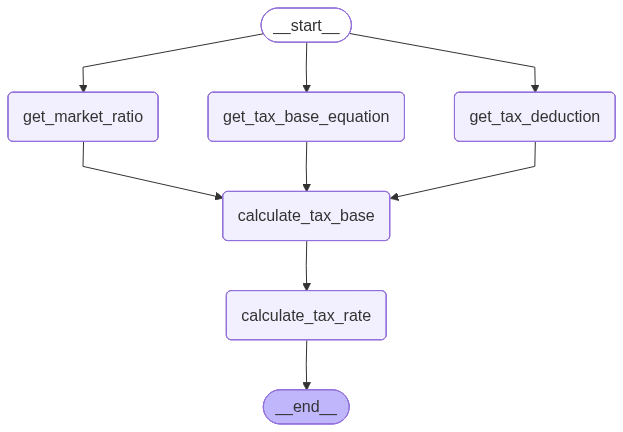

In [38]:
from IPython.display import Image, display

png_bytes = graph.get_graph().draw_mermaid_png()
display(Image(data=png_bytes))

[{'title': '2026년 종부세 공정시장가액비율 80% 상향, 어떤 변화가 올까?', 'url': 'https://mystery225.tistory.com/193', 'content': '카테고리 없음\n\n## 2026년 종부세 공정시장가액비율 80% 상향, 어떤 변화가 올까?\n\nMystic Chronicles 2025. 8. 23. 22:21\n\n안녕하세요, 부동산 세금에 관심 있는 분들을 위한 소식을 전해드리는 부동산 세금 가이드 블로그입니다! 오늘은 2026년에 예정된 종합부동산세(종부세) 공정시장가액비율 80% 상향에 대해 자세히 알아보고, 이 변화가 주택 소유자와 부동산 시장에 어떤 영향을 미칠지 쉽게 풀어볼게요.\n\n종부세와 공정시장가액비율이란?   \n종부세는 고가의 부동산을 보유한 사람들에게 부과되는 세금으로, 주택이나 토지의 공시가격을 기준으로 계산됩니다. 여기서 공정시장가액비율은 공시가격에 곱해져 종부세 과세표준을 결정하는 중요한 요소예요. 쉽게 말해, 공시가격의 일정 비율만 세금 계산에 반영되는 거죠.   \n현재(2025년 기준) 공정시장가액비율은 주택의 경우 60%로 적용되고 있어요. 예를 들어, 공시가격이 10억 원인 주택은 60%인 6억 원을 기준으로 종부세를 계산합니다. 하지만 2026년에는 이 비율이 80%로 상향될 가능성이 높아졌다는 소식이 전해지고 있죠. [...] 왜 80%로 상향되나?   \n정부는 종부세 공정시장가액비율을 60%에서 80%로 올리는 방안을 적극 검토 중이에요. 이는 윤석열 정부가 이전에 낮췄던 종부세 부담을 원상 복구하려는 취지로 보입니다. 특히, 최근 서울 강남권을 중심으로 고가 주택이 증가하면서 세수 확보 필요성이 커졌기 때문이죠.   \n문재인 정부 시절 공정시장가액비율은 95%까지 올랐었지만, 2022년 윤석열 정부 들어 60%로 낮아졌어요. 하지만 세수 부족 문제가 심화되면서, 정부는 비율을 다시 80%로 조정해 세입을 적정 수준으로 맞추려는 계획을 세우고 있는 것으로 보여요. 이